In [2]:
import torch
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from torch.utils.data import DataLoader, TensorDataset
import csv
import numpy as np

### Data Loader

In [3]:
csv_file_path = '../parsed_data.csv'
parsed_data = []
parsed_signal_data = []
with open(csv_file_path, 'r') as csvfile:
    csv_reader = csv.reader(csvfile)
    
    for row in csv_reader:
        data_point = [float(value) for value in row]
        parsed_data.append(data_point)

print(len(parsed_data))

with open("../parsed_signal_data.csv", 'r') as csvfile:
    csv_reader = csv.reader(csvfile)
    
    for row in csv_reader:
        data_point = [float(value) for value in row]
        parsed_signal_data.append(data_point)

print(len(parsed_signal_data))

350181
53000


In [4]:
for arr in parsed_data:
    for i in range(len(arr)):
        if i % 3 ==0:
            arr[i] = arr[i] /100.0
print("done with background")
for arr in parsed_signal_data:
    for i in range(len(arr)):
        if i % 3 ==0:
            arr[i] = arr[i] /100.0

done with background


In [5]:
class AutoEncoder(torch.nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(18, 6),
            torch.nn.ReLU(),
            torch.nn.Linear(6, 18),
            torch.nn.ReLU(),
            torch.nn.Linear(18, 9),
            torch.nn.ReLU(),
            torch.nn.Linear(9, 3),
        )
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(3, 9),
            torch.nn.ReLU(),          # gonna try sigmoid here as well
            torch.nn.Linear(9, 18),
            torch.nn.ReLU(),
            torch.nn.Linear(18, 6),  
            torch.nn.ReLU(),
            torch.nn.Linear(6, 18),
            torch.nn.ReLU(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    def encode(self, x):
        return self.encoder(x)

In [6]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('GPU is available')
else:
    device = torch.device('cpu')
    print('GPU not available, CPU used')

GPU is available


In [7]:
background_tensor_data = torch.tensor(parsed_data, dtype=torch.float)
background_dataset = TensorDataset(background_tensor_data)
background_dataloader = DataLoader(background_dataset, batch_size=8192, shuffle=False)

signal_tensor_data = torch.tensor(parsed_signal_data, dtype=torch.float)
signal_dataset = TensorDataset(signal_tensor_data)
signal_dataloader = DataLoader(signal_dataset, batch_size=8192, shuffle=False)

model = AutoEncoder()  # Replace with your actual model class name
model.load_state_dict(torch.load('../model/autoencoder_model_3.pth', map_location=device))
model.to(device)
model.eval()

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=18, out_features=6, bias=True)
    (1): ReLU()
    (2): Linear(in_features=6, out_features=18, bias=True)
    (3): ReLU()
    (4): Linear(in_features=18, out_features=9, bias=True)
    (5): ReLU()
    (6): Linear(in_features=9, out_features=3, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=3, out_features=9, bias=True)
    (1): ReLU()
    (2): Linear(in_features=9, out_features=18, bias=True)
    (3): ReLU()
    (4): Linear(in_features=18, out_features=6, bias=True)
    (5): ReLU()
    (6): Linear(in_features=6, out_features=18, bias=True)
    (7): ReLU()
  )
)

In [8]:
def get_encoded_features(dataloader):
    encoded_features = []
    with torch.no_grad():
        for data in dataloader:
            input = data[0].to(device)
            encoded = model.encode(input)
            encoded_features.append(encoded.cpu().numpy())
    return np.concatenate(encoded_features, axis=0)

background_encoded = get_encoded_features(background_dataloader)
signal_encoded = get_encoded_features(signal_dataloader)

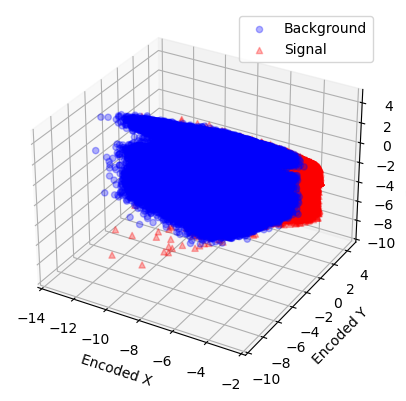

In [11]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# Plotting the encoded features
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot background features
ax.scatter(background_encoded[:, 0], background_encoded[:, 1], background_encoded[:, 2], c='b', marker='o', label='Background', alpha=0.3)

# Plot signal features
ax.scatter(signal_encoded[:, 0], signal_encoded[:, 1], signal_encoded[:, 2], c='r', marker='^', label='Signal', alpha=0.3)

ax.set_xlim(-14, -2)
ax.set_ylim(-10, 5)
ax.set_zlim(-10, 5)
# Labeling
ax.set_xlabel('Encoded X')
ax.set_ylabel('Encoded Y')
ax.set_zlabel('Encoded Z')
ax.legend()

# Show plot
plt.show()


In [12]:
subset_size = 1000

background_indices_subset = np.random.choice(background_encoded.shape[0], subset_size, replace=False)

signal_indices_subset = np.random.choice(signal_encoded.shape[0], subset_size, replace=False)

background_encoded_subset = background_encoded[background_indices_subset, :]
signal_encoded_subset = signal_encoded[signal_indices_subset, :]

In [21]:
import plotly.graph_objs as go

# Create traces for the background and signal
background_trace = go.Scatter3d(
    x=background_encoded_subset[:, 0],
    y=background_encoded_subset[:, 1],
    z=background_encoded_subset[:, 2],
    mode='markers',
    marker=dict(
        size=5,
        color='blue',  # choose a color for background
        opacity=0.8
    ),
    name='Background'
)

signal_trace = go.Scatter3d(
    x=signal_encoded_subset[:, 0],
    y=signal_encoded_subset[:, 1],
    z=signal_encoded_subset[:, 2],
    mode='markers',
    marker=dict(
        size=5,
        color='red',  # choose a color for signal
        opacity=0.8
    ),
    name='Signal'
)

# Define the layout of the plot
layout = go.Layout(
    margin=dict(l=0, r=0, b=0, t=0),
    scene=dict(
        xaxis=dict(title='Encoded X'),
        yaxis=dict(title='Encoded Y'),
        zaxis=dict(title='Encoded Z')
    )
)

# Create the figure
fig = go.Figure(data=[background_trace, signal_trace], layout=layout)

# Plot the figure
fig.show()


### K-Means Clustering

In [14]:
encoded_combined = np.vstack((background_encoded_subset, signal_encoded_subset))

In [15]:
from sklearn.cluster import KMeans

k=2

kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(encoded_combined)

cluster_labels = kmeans.labels_

c:\ProgramData\Anaconda3\envs\isef\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\ProgramData\Anaconda3\envs\isef\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.



In [16]:
import plotly.graph_objs as go

# Create a trace for the clusters
cluster_trace = go.Scatter3d(
    x=encoded_combined[:, 0],
    y=encoded_combined[:, 1],
    z=encoded_combined[:, 2],
    mode='markers',
    marker=dict(
        size=5,
        color=cluster_labels,  # set color to cluster labels
        colorscale='Viridis',  # choose a color scale
        opacity=0.8
    )
)

# Define the layout of the plot
layout = go.Layout(
    margin=dict(l=0, r=0, b=0, t=0),
    scene=dict(
        xaxis=dict(title='Encoded X'),
        yaxis=dict(title='Encoded Y'),
        zaxis=dict(title='Encoded Z')
    )
)

# Create the figure
fig = go.Figure(data=[cluster_trace], layout=layout)

# Plot the figure
fig.show()


In [17]:
from sklearn.metrics import confusion_matrix

true_labels = np.concatenate([np.zeros(len(background_encoded_subset)), np.ones(len(signal_encoded_subset))])

cm = confusion_matrix(true_labels, cluster_labels)

print(cm)

[[943  57]
 [ 66 934]]


- increase number of dimensions
- always apply k-means
- try another signal dataset, see if performs the same or different (measure performance)
- tweak the parameters of the model
- goal is to have a difference in performance between signal and background when doing full auto-encoding

Normalize the matrix